# End-to-End Machine Learning Project

## Appendix

1. [Frame the Problem and Look at the Big Picture](#frame-the-problem-and-look-at-the-big-picture)
2. [Get the Data](#get-the-data)
3. [Explore the Data](#explore-the-data)
4. [Prepare the Data](#prepare-the-data)
5. [Shortlist Promising Models](#shortlist-promising-models)
6. [Fine-Tune the System](#fine-tune-the-system)
7. [Present Your Solution](#present-your-solution)
8. [Launch](#launch)

## Frame the Problem and Look at the Big Picture

### Frame the Problem

We have been tasked with using the California census data to build a model of housing prices in the state.

The model should output a district's median housing price. This output will be used as input for a downstream model.

The current solution involves experts manually running complex rules to determine the district's median housing prices. Often they have inaccurate measurements (off by >20%).

We are tasked with predicting a continuous single value using labeled data with multiple features that is not in the form of a stream (live). This means we will be looking at a multiple univariate regression with batch learning.

### Select a Performance Measure

For regression we tend to choose Root Mean Square Error (RMSE) or Mean Absolute Error (MAE) for our performance measure.

Both measure the distance between two vectors. RMSE corresponds to the L2 norm while MAE corresponds to the L1 norm.

The higher the norm index the more it focuses on large values and neglects small ones. Due to this RMSE is more sensitive to outliers than MAE but works better in bell-shaped curve data.

$RMSE(X,h) = \sqrt{\frac{1}{m}\sum_{i=1}^{m}(h(x^{(i)}) - y^{(i)})^2}$

$MAE(X,h) = \frac{1}{m}\sum_{i=1}^{m}|h(x^{(i)}) - y^{(i)}|$

$h(x^{(i)}) = \hat{y}^{(i)}$

We can begin with RMSE and switch to MAE if we are seeing outliers.

## Get the Data

In [18]:
import os
import tarfile
import urllib
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """
    Gets most recent housing.tgz from github path and downloads locally to datasets/housing/ and extracts to csv
    """
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    """
    Creates a dataframe from the housing.csv data
    """
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
fetch_housing_data()
housing = load_housing_data()

## Explore the Data

In [7]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [10]:
housing['ocean_proximity'].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [11]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


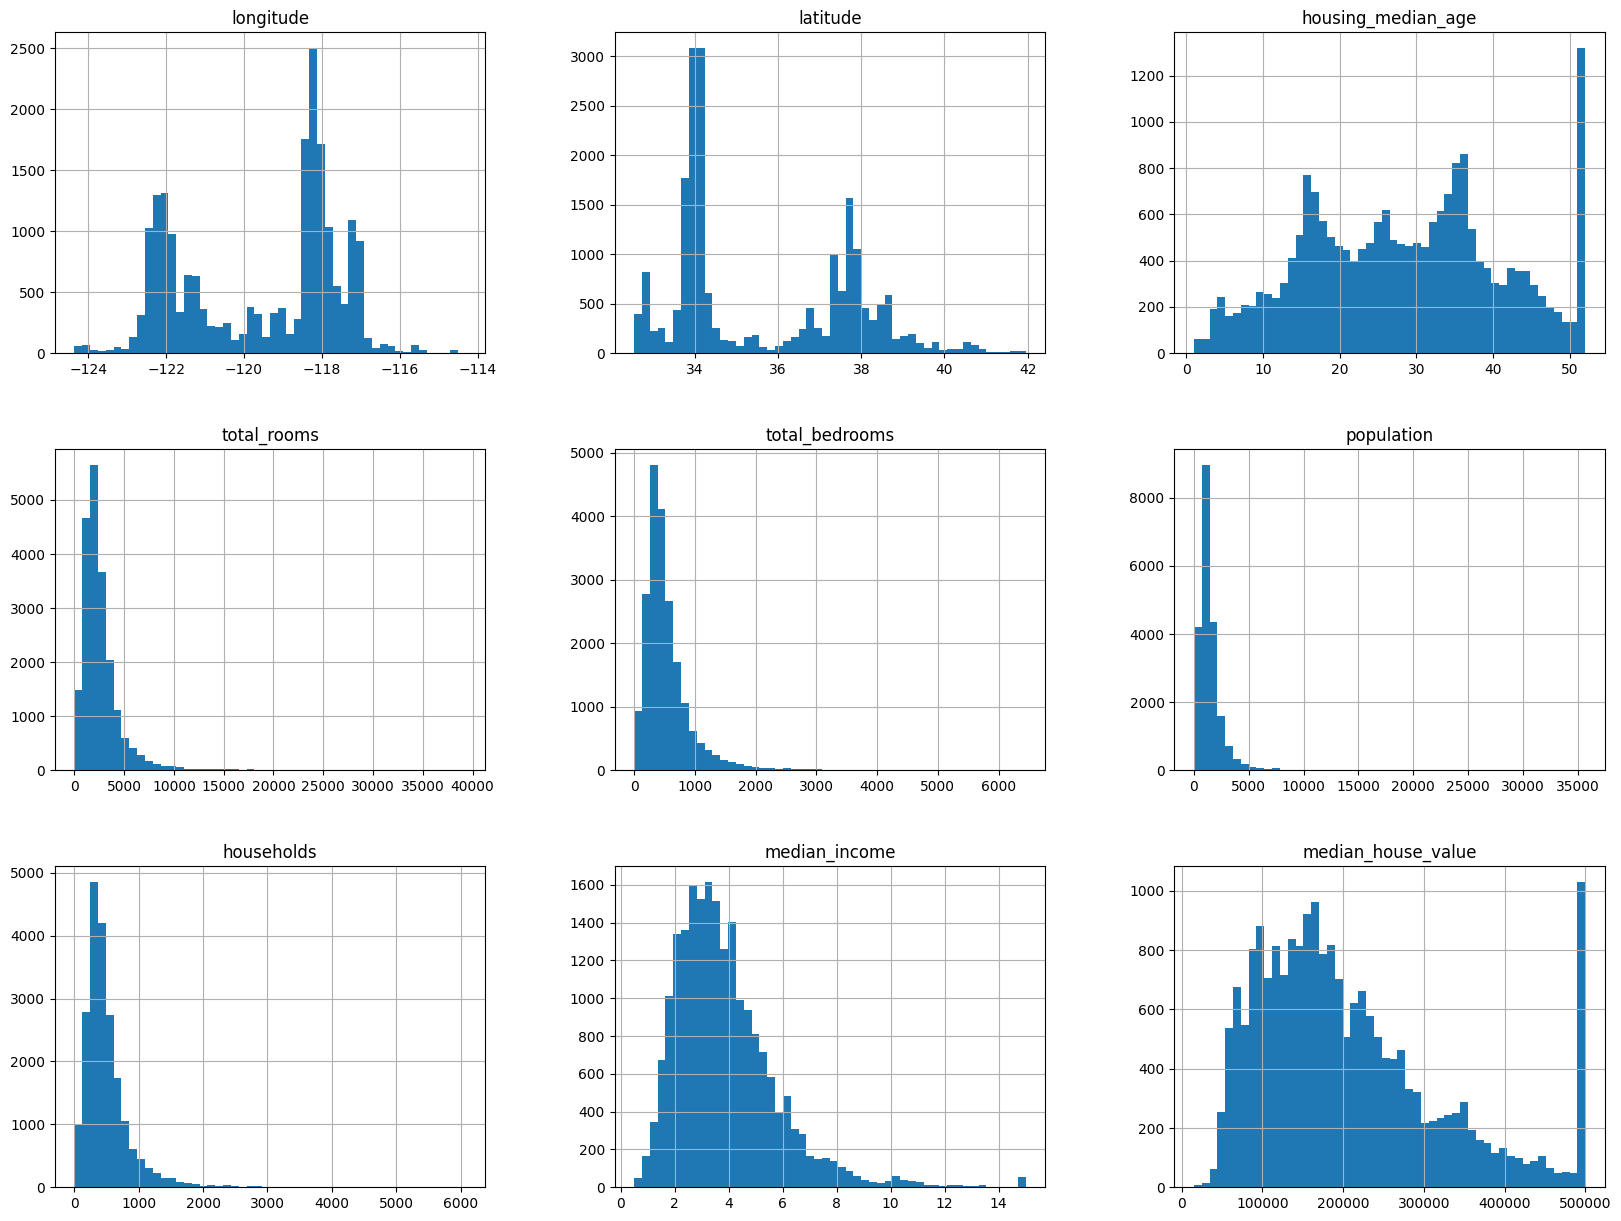

In [23]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

* `median_income` - appears to range from 0 to 15 not USD. It turns out this is a scaled income where the numbers are $10,000x. So at 3 this would mean $30,000.

* `housing_median_age` - appears it was capped at 50 we must ensure this is not an issue downstream with the model team ingesting our result.

* `median_house_value` - appears it was capped at $500,000 we must ensure this is not an an issue downstream with the model team ingesting our result.

* Our features have very wide scale differences which will need to be handled in data preparation.

* Some features are showing heavy right skew tailing and will need to be transformed in data preparation.

### Create a Test Set

We are creating a test set early to avoid **data snooping bias**.

Experts informed us that the median income is an extremely important attribute for predicting median housing prices. We want to ensure that the test set is reprsentative of the various cateogires of incomes.

First we will categorize the continuous `median_income` feature and use the new categorical feature to do a stratified shuffling to ensure that there are even amounts in the train and test datasets.

In [16]:
housing['income_cat'] = (pd
    .cut(housing['median_income'],
        bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
        labels=[1,2,3,4,5,])
)

<Axes: >

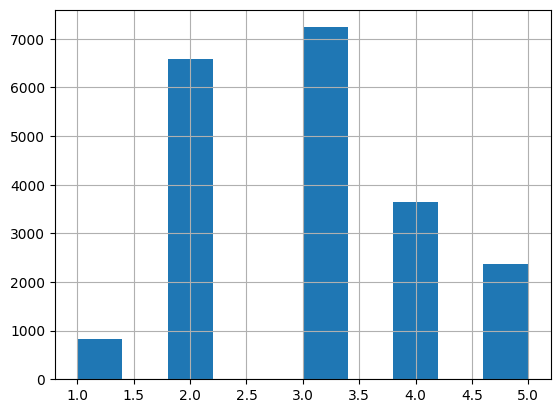

In [17]:
housing['income_cat'].hist()

In [19]:
split = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [20]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

In [21]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [22]:
for set_ in [strat_test_set, strat_train_set]:
    set_.drop('income_cat', axis=1, inplace=True)

### Data Exploration

In [26]:
housing = strat_train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

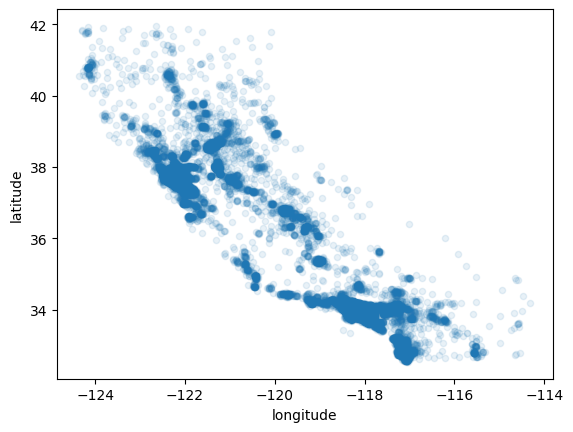

In [31]:
housing.plot(
    kind='scatter', 
    x='longitude', 
    y='latitude', 
    alpha=0.1
    )

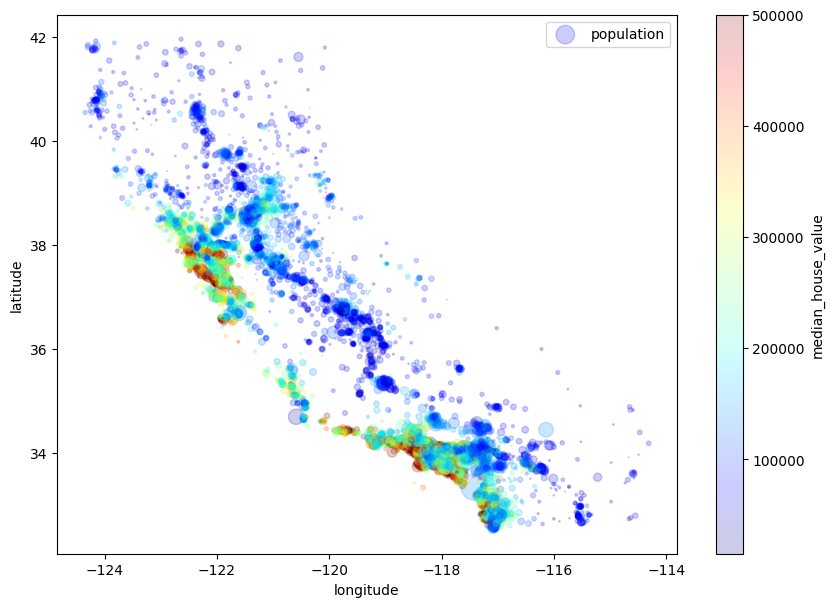

In [41]:
housing.plot(
    kind='scatter',
    x='longitude',
    y='latitude',
    alpha=0.2,
    s=housing['population']/100,
    label='population',
    figsize=(10,7),
    c='median_house_value',
    cmap=plt.get_cmap('jet'),
)

plt.legend()

## Prepare the Data

## Shortlist Promising Models

## Fine-Tune the System

## Present Your Solution

## Launch